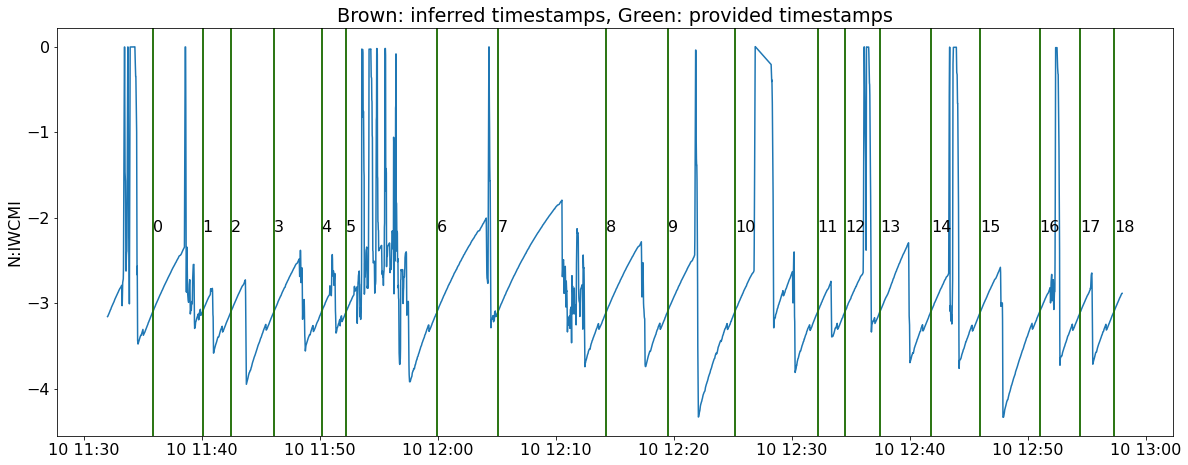

In [10]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
from fur.path_assistant import PathAssistant
shift = PathAssistant('shift_03_10_2020',      
    ignore_files=["RefCurve_2020-03-10_0_111937_test.Wfm.bin"])
results_dir = shift.get_results_dir()
bpm_files_df = shift.get_bpm_files_df()
timestamps = bpm_files_df["file_datetime"].apply(lambda t: t.round(freq='S'))[1:]
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data
fluctuations_df = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_nd_filters_data_03_10_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.3.6ds_data.txt",
    provided_timestamps=timestamps,
    show_plot=True
)
from config import get_from_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy

In [11]:
desc = fluctuations_df.describe()
desc

,ch2_amplitude,var_of_ch1_amplitude,noise_var,var_of_ch1_amplitude_err,noise_var_err,N:IWCMI,N:IBEAMA,N:IWCMBE,N:IWCMBR,N:IWCMBF,N:IWCMBG,N:IRFEPA,N:ITC1RSH,N:ITC2RSH,N:ITC3RSH,N:ITC4RSH,N:ITC4LSH,N:ITC3LSH,N:ITC2LSH,N:ITC1LSH,N:ITC1RSV,N:ITC2RSV,N:ITC3RSV,N:ITC4RSV,N:ITC4LSV,N:ITC3LSV,N:ITC2LSV,N:ITC1LSV,N:IWCMI_recalibrated_to_IWCMI_absolute,N:IBEAM_recalibrated_to_IWCMI_absolute,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y,ex_um,ex_err,ey_um,ey_err,dp/p,dp/p_err
count,19.000000,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,0.306173,1.825778e-08,8.679781e-08,1.451799e-10,5.112121e-11,-3.101046,-2.834816,29.496419,31.904693,64.245359,28.090796,382.245298,481.748188,1453.995658,1679.299200,7.327710e+02,1103.675418,1684.906068,1592.881008,514.511205,118.851636,82.495185,98.920255,105.9989,167.087819,76.374799,73.138058,141.714046,-2.743075,-2.740521,1192.664755,19.040887,93.954513,7.423908,0.000913,0.000127,0.661710,0.022306,0.008972,0.001417,0.000271,0.0
std,0.162183,1.362985e-08,8.470340e-10,2.996995e-11,1.060343e-11,0.005150,0.018760,0.203873,0.241050,0.295263,0.175942,0.142068,4.737316,15.531610,17.480483,1.168021e-13,11.197518,18.908706,16.056571,5.318114,2.834607,0.479621,1.049557,0.0000,2.289309,1.392110,0.602125,3.180232,0.004555,0.018136,12.392267,0.254871,1.607838,0.098280,0.000010,0.000002,0.014029,0.000439,0.000304,0.000008,0.000002,0.0
min,0.069349,2.174498e-09,8.552979e-08,9.677293e-11,3.408032e-11,-3.108926,-2.872040,29.250820,31.601951,63.895694,27.889435,381.852059,474.122360,1431.053000,1654.111500,7.327710e+02,1087.159550,1651.745500,1569.714450,506.609985,112.151400,81.396652,96.463402,105.9989,161.394355,73.134651,71.725651,134.110295,-2.750046,-2.776507,1175.296370,18.663058,90.039301,7.291602,0.000899,0.000122,0.642139,0.021718,0.008238,0.001401,0.000268,0.0
25%,0.156337,6.217945e-09,8.599153e-08,1.212186e-10,4.247073e-11,-3.104934,-2.850180,29.364662,31.744149,64.068942,27.955642,382.182238,479.333208,1442.651000,1666.520525,7.327710e+02,1095.714750,1670.604500,1580.922025,510.531488,117.852350,82.242502,98.659824,105.9989,166.660503,76.020798,72.985376,141.015350,-2.746514,-2.755374,1182.581108,18.861790,93.624910,7.351938,0.000905,0.000126,0.650338,0.021837,0.008907,0.001414,0.000270,0.0
50%,0.330092,1.619522e-08,8.703252e-08,1.477996e-10,5.212625e-11,-3.099760,-2.831030,29.455165,31.842225,64.179280,28.059129,382.224520,480.729950,1452.495000,1677.310500,7.327710e+02,1103.061050,1684.347550,1591.022600,513.877015,118.813800,82.592598,99.101402,105.9989,167.428410,76.537598,73.290199,142.282700,-2.741937,-2.736861,1191.417600,19.032310,94.213229,7.415780,0.000912,0.000127,0.660398,0.022349,0.009019,0.001419,0.000270,0.0
75%,0.400000,2.446134e-08,8.759808e-08,1.682981e-10,5.940221e-11,-3.097338,-2.821781,29.556785,31.979952,64.332788,28.128610,382.318617,483.362305,1460.409950,1686.526500,7.327710e+02,1108.463550,1693.994050,1599.957500,516.741485,120.394350,82.862177,99.736000,105.9989,168.966922,77.490576,73.605900,144.251053,-2.739795,-2.727920,1197.995753,19.121056,95.161727,7.455044,0.000917,0.000128,0.667843,0.022618,0.009202,0.001421,0.000272,0.0
max,0.603888,5.001538e-08,8.789643e-08,2.097333e-10,7.399451e-11,-3.091189,-2.805270,30.004467,32.516025,64.929670,28.520181,382.490759,492.874390,1485.176450,1716.412000,7.327710e+02,1126.425050,1722.187450,1626.731550,525.666475,123.753490,83.040550,100.070300,105.9989,169.414090,77.887497,73.802299,144.950100,-2.734356,-2.711958,1218.335835,19.748678,95.886572,7.656017,0.000932,0.000129,0.690607,0.023228,0.009342,0.001427,0.000276,0.0


In [12]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']

In [13]:
errors_df = pd.DataFrame(index=size_names)

In [14]:
errors_df['mean'] = desc.loc['mean', size_names]

In [15]:
errors_df["timing_related_std"] = desc.loc['std', size_names]

In [16]:
errors_df["single_measurement_std"] = desc.loc['mean', ['Sigma_um_X_err', 'Sigma_um_Y_err']].to_list()+[0]

In [17]:
errors_df

,mean,timing_related_std,single_measurement_std
Sigma_um_X,1192.664755,12.392267,19.040887
Sigma_um_Y,93.954513,1.607838,7.423908
N:IWCMBE,29.496419,0.203873,0.000000


In [18]:
errors_df["tot_std"] = (errors_df['timing_related_std']**2+errors_df['single_measurement_std']**2).apply(np.sqrt)
errors_df

,mean,timing_related_std,single_measurement_std,tot_std
Sigma_um_X,1192.664755,12.392267,19.040887,22.718355
Sigma_um_Y,93.954513,1.607838,7.423908,7.596023
N:IWCMBE,29.496419,0.203873,0.000000,0.203873


In [19]:
sizes = errors_df['mean']
sigma_x_um, sigma_y_um, sigma_z_cm = sizes


In [20]:
# sigma_x = sigma_x_um
# sigma_y = sigma_y_um
# sigma_z = sigma_z_cm*1e4
# from wiggler_radiation.number_of_coherent_modes.coherent_modes \
#     import get_My
# import numpy as np
# from wiggler_radiation.wiggler_radiation import get_photon_flux_3D
# from wiggler_radiation.Wigrad.wigrad_generator import get_rad_mesh_tuple

In [21]:
# x_1D, y_1D, l_1D = get_rad_mesh_tuple()
# i_3D = get_photon_flux_3D(source='wigrad')

In [22]:
# My = get_My(sigma_y, get_rad_mesh_tuple(), i_3D)
# M = My*sigma_x*sigma_z
# # M = 4658702.622234305

In [23]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [24]:
M = Mfunc(*sizes)
M

4326135.048448588

## determining error of M

In [25]:
sx_std, sy_std, sz_std = errors_df['tot_std']
M_std = np.sqrt(
    (Mxder(*sizes)*sx_std)**2
    +(Myder(*sizes)*sy_std)**2
    +(Mzder(*sizes)*sz_std)**2
)
M_std

207673.94440838354

In [26]:
M_std_en = get_from_config("Beam_energy_error_MeV")*Meder(*sizes)
M_std_en

517005.0515474356

In [27]:
M_std_with_en = np.sqrt(M_std**2+M_std_en**2)
M_std_with_en

557155.8942627305

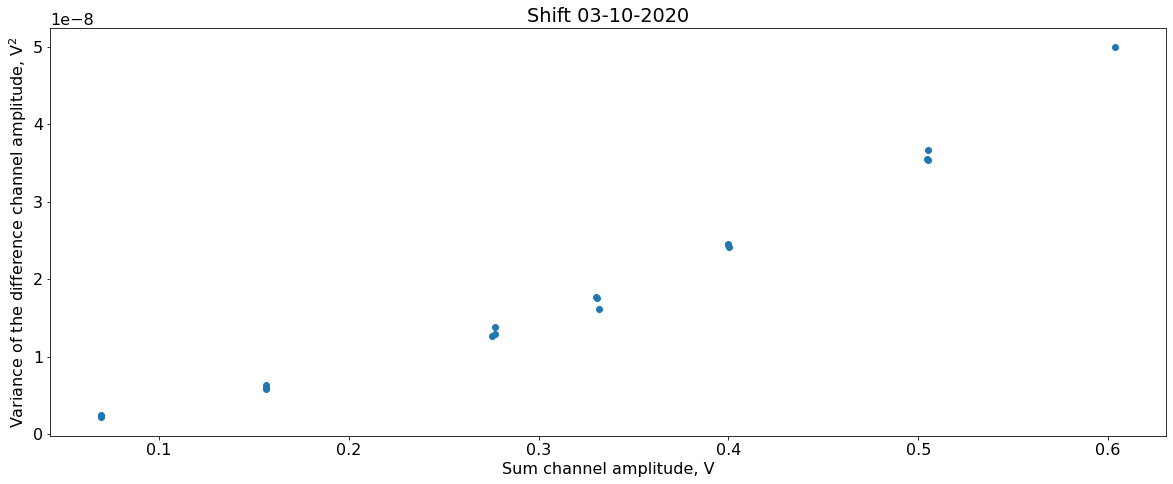

In [28]:
plt.plot(fluctuations_df["ch2_amplitude"].values, fluctuations_df["var_of_ch1_amplitude"].values, 'o')
plt.xlabel("Sum channel amplitude, V")
plt.ylabel("Variance of the difference channel amplitude, V$^2$")
plt.title(r"Shift 03-10-2020")
plt.show()

In [29]:
sum_channel_to_photoelectrons = get_from_config("sum_channel_to_photoelectrons")

In [30]:
N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
fluctuations_df['N'] = N
fluctuations_df['varN'] = varN

In [31]:
from scipy.optimize import curve_fit
def var_theor(x, M):
    return x+1/M*x**2
popt, pcov = curve_fit(var_theor, N, varN)
Mfit = popt[0]
Mfit_err = np.sqrt(np.diag(pcov))[0]
Mfit, Mfit_err

(4421968.316302349, 42843.20346508419)

In [32]:
3.005*get_from_config("IWCMI_to_WCM_ABSOLUTE")

2.658115877930119

In [33]:
def as_si(x, ndp):
    """Returns number in scientific format for latex. For PyPlot when latex output is needed. 
    Latex distibtuion must be installed on the machine. Also set  plt.rcParams["text.usetex"] =True
    Parameters
    ----------
    x
        the input number
    ndp : int
        desired number of decimals
    """
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'${m:s}\times 10^{{{e:d}}}$'.format(m=m, e=int(e))

In [60]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")

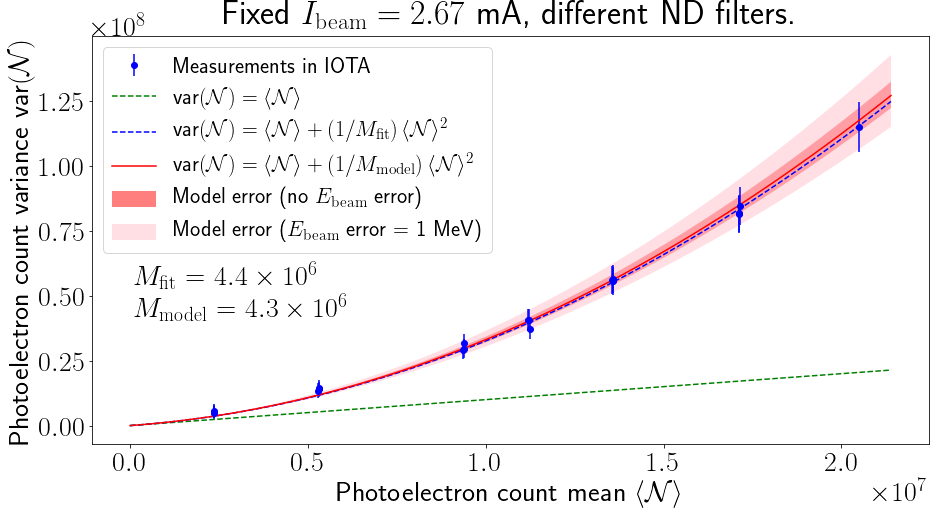

In [61]:
hybrid_errorbar = 2*hybrid_balance_error*np.absolute(varN)
error_bar = np.sqrt(hybrid_errorbar**2+fit_errorbar**2)
#0.33*5.231532189534264e-09*2*sum_channel_to_photoelectrons**2
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(N,varN,marker='o',linestyle='None',yerr=error_bar,color='b', label = 'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.plot(x_aux, var_theor(x_aux, Mfit),color='blue', linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{\mathrm{fit}}\right)\langle\mathcal{N}\rangle^2$")
ax.plot(x_aux, var_theor(x_aux, M),color='red',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{\mathrm{model}}\right)\langle\mathcal{N}\rangle^2$")
ax.fill_between(x_aux, var_theor(x_aux, M+M_std), var_theor(x_aux, M-M_std), facecolor='red', alpha=0.5, label='Model error (no $E_{\mathrm{beam}}$ error)')
ax.fill_between(x_aux, var_theor(x_aux, M+M_std_with_en), var_theor(x_aux, M-M_std_with_en), facecolor='pink', alpha=0.5, label='Model error ($E_{\mathrm{beam}}$ error = 1 MeV)')
ax.legend()
handles, labels = plt.gca().get_legend_handles_labels()
order = [5,0,1,2,3,4]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_title("Fixed $I_{\mathrm{beam}} = 2.67$ mA, different ND filters.")
ax.text(0.05,0.63-0.25,r"$M_{\mathrm{fit}}$"+" = {:s}".format(as_si(Mfit,1)),transform=ax.transAxes)
ax.text(0.05,0.55-0.25,r'$M_{\mathrm{model}}$'+' = {:s}'.format(as_si(M,1)),transform=ax.transAxes)
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
plt.show()